# Prep

## Library

In [125]:
from ds_common_utils.aux.io.snowflake_tools import SnowflakeTools
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import matplotlib.lines as mlines

## Connection

In [2]:
con = SnowflakeTools(
    role="INSIGHT_ANALYST_MERCH_DE_GENERAL_PRD",
    warehouse="INSIGHT_ANALYST_WH",
    database="BDWPRD_DE",
    schema="IA_MERCH_DE"
)

## Item list

In [22]:
# Load both AU and NZ sheets from the Excel file
item_list = pd.read_excel("Item list.xlsx", sheet_name=None)

# Replace sheet names if needed
au_items = item_list['AU']
nz_items = item_list['NZ']

# Standardise column names (optional but helpful)
au_items.columns = au_items.columns.str.strip().str.lower()
nz_items.columns = nz_items.columns.str.strip().str.lower()

# Ensure item_number is string with leading zeroes
au_items['item_number'] = au_items['item_number'].astype(str).str.zfill(7)
nz_items['item_number'] = nz_items['item_number'].astype(str).str.zfill(7)

Index(['item_number', 'item_description'], dtype='object')
Index(['item_number', 'item_description'], dtype='object')


In [24]:
# Read product hierarchy
product_hierarchy = con.read_sql_file_into_pandas(
    file="sql/item-hierarchy.sql"
)

In [25]:
# Clean column names
product_hierarchy.columns = (
    product_hierarchy.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
)

# Ensure item_number is string with 7-digit padding
product_hierarchy['item_number'] = product_hierarchy['item_number'].astype(str).str.zfill(7)

In [26]:
# Merge enriched hierarchy into AU and NZ item lists
au_items_enriched = au_items.merge(product_hierarchy, on='item_number', how='left')
nz_items_enriched = nz_items.merge(product_hierarchy, on='item_number', how='left')


In [29]:
# Function to print unique values for each hierarchy column
def show_unique_hierarchy(df, label):
    print(f"\n🔹 {label}: Unique item_category_name")
    print(df['item_category_name'].dropna().unique())

    print(f"\n🔹 {label}: Unique item_department_name")
    print(df['item_department_name'].dropna().unique())

    print(f"\n🔹 {label}: Unique item_sub_department_name")
    print(df['item_sub_department_name'].dropna().unique())

    print(f"\n🔹 {label}: Unique item_class_name")
    print(df['item_class_name'].dropna().unique())

    print(f"\n🔹 {label}: Unique item_sub_class_name")
    print(df['item_sub_class_name'].dropna().unique())

# Show for both AU and NZ
show_unique_hierarchy(au_items_enriched, "AU ITEMS")
show_unique_hierarchy(nz_items_enriched, "NZ ITEMS")



🔹 AU ITEMS: Unique item_category_name
['200 TIMBER']

🔹 AU ITEMS: Unique item_department_name
['300 INDOOR TIMBER AND BOARDS']

🔹 AU ITEMS: Unique item_sub_department_name
['400 PANELS']

🔹 AU ITEMS: Unique item_class_name
['500 PANELS' '500 PANELS BULK STACK']

🔹 AU ITEMS: Unique item_sub_class_name
['600 EXOTIC PANELS' '600 PANELS BULK STACK' '600 PANELS'
 '600 DRESSED PINE PNL BULK STCK']

🔹 NZ ITEMS: Unique item_category_name
['200 TIMBER']

🔹 NZ ITEMS: Unique item_department_name
['300 INDOOR TIMBER AND BOARDS']

🔹 NZ ITEMS: Unique item_sub_department_name
['400 PANELS']

🔹 NZ ITEMS: Unique item_class_name
['500 PANELS' '500 PANELS BULK STACK']

🔹 NZ ITEMS: Unique item_sub_class_name
['600 EXOTIC PANELS' '600 PANELS' '600 PANELS BULK STACK'
 '600 DRESSED PINE PNL BULK STCK']


# Class-based Performance

In [121]:
start_date = "'2024-07-31'"
end_date = "'2025-06-11'"
start_date_LY = "'2023-07-31'"
end_date_LY = "'2024-06-11'"
start_rrp_date = "2025-01-27"

## AU

In [74]:
country = "'AU'"

In [96]:
df_class_transactions = con.read_sql_file_into_pandas(
    file="sql/class-transactions.sql",
    formatting={
        'start_date': start_date,
        'end_date': end_date,
        'country': country
    }
)

print(df_class_transactions.head())

  WEEK_START ITEM_NUMBER                            ITEM_DESCRIPTION  \
0 2024-07-29     0215400  TAS OAK FEATURE GRADE PANEL++1800X600X19MM   

  ITEM_CLASS_NAME ITEM_SUB_CLASS_NAME  TOTAL_SALES  TOTAL_QUANTITY  \
0      500 PANELS          600 PANELS      2954.51            25.0   

   UNIQUE_CUSTOMERS  
0                21  


In [111]:
df_class_transactions_LY = con.read_sql_file_into_pandas(
    file="sql/class-transactions.sql",
    formatting={
        'start_date': start_date_LY,
        'end_date': end_date_LY,
        'country': country
    }
)

print(df_class_transactions_LY.head())

  WEEK_START ITEM_NUMBER                                   ITEM_DESCRIPTION  \
0 2023-07-31     0019144          PINE FJ LAM UTILITY PANEL++1200X405X18MM^   
1 2023-07-31     0019145          PINE FJ LAM UTILITY PANEL++1200X300X18MM^   
2 2023-07-31     0019146          PINE FJ LAM UTILITY PANEL++1200X600X18MM^   
3 2023-07-31     0019147          PINE FJ LAM UTILITY PANEL++1800X405X18MM^   
4 2023-07-31     0123329  TAS OAK SELECT GRADE PANEL++1200X405X17MM TIMB...   

  ITEM_CLASS_NAME ITEM_SUB_CLASS_NAME  TOTAL_SALES  TOTAL_QUANTITY  \
0      500 PANELS          600 PANELS        90.00             5.0   
1      500 PANELS          600 PANELS       645.80            36.0   
2      500 PANELS          600 PANELS       338.18            12.0   
3      500 PANELS          600 PANELS        98.18             2.0   
4      500 PANELS          600 PANELS       261.81             9.0   

   UNIQUE_CUSTOMERS  
0                 2  
1                19  
2                 8  
3               

In [118]:
# Clean and prep both current and last year's datasets
def prepare_df(df, au_items_enriched, start_rrp_date, label):
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
    df['item_number'] = df['item_number'].astype(str).str.zfill(7)
    df['week_start'] = pd.to_datetime(df['week_start'])
    df['rrp_increase'] = df['item_number'].isin(au_items_enriched['item_number']).map({True: 'Yes', False: 'No'})
    cutoff_date = pd.to_datetime(start_rrp_date)
    df['period'] = df['week_start'].apply(lambda x: 'Pre' if x < cutoff_date else 'Post')
    df['year_label'] = label
    return df

# Apply cleaning
df_class_transactions = prepare_df(df_class_transactions, au_items_enriched, start_rrp_date, 'This Year')
df_class_transactions_LY = prepare_df(df_class_transactions_LY, au_items_enriched, start_rrp_date, 'Last Year')

# Combine both
df_all = pd.concat([df_class_transactions, df_class_transactions_LY], ignore_index=True)

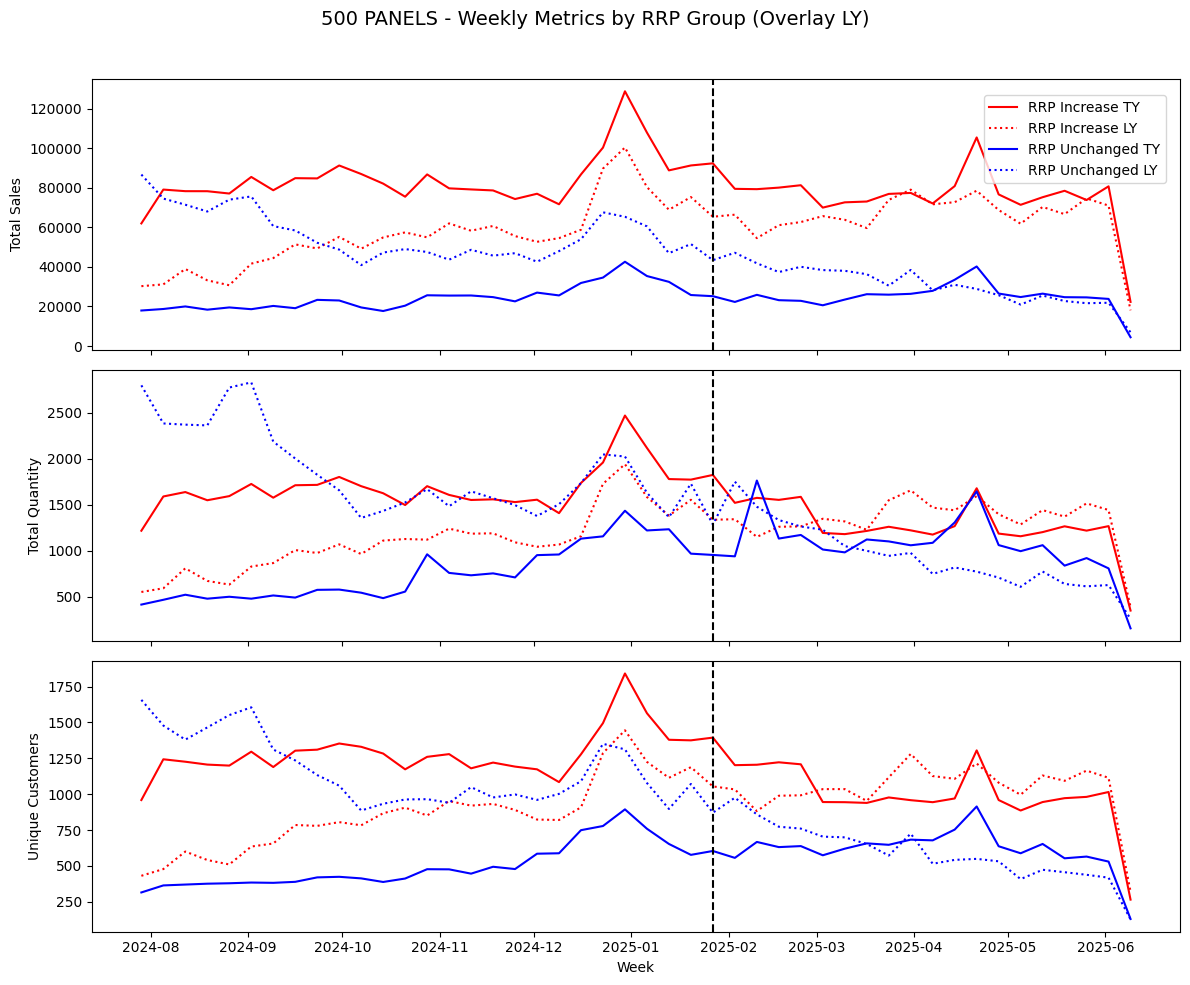

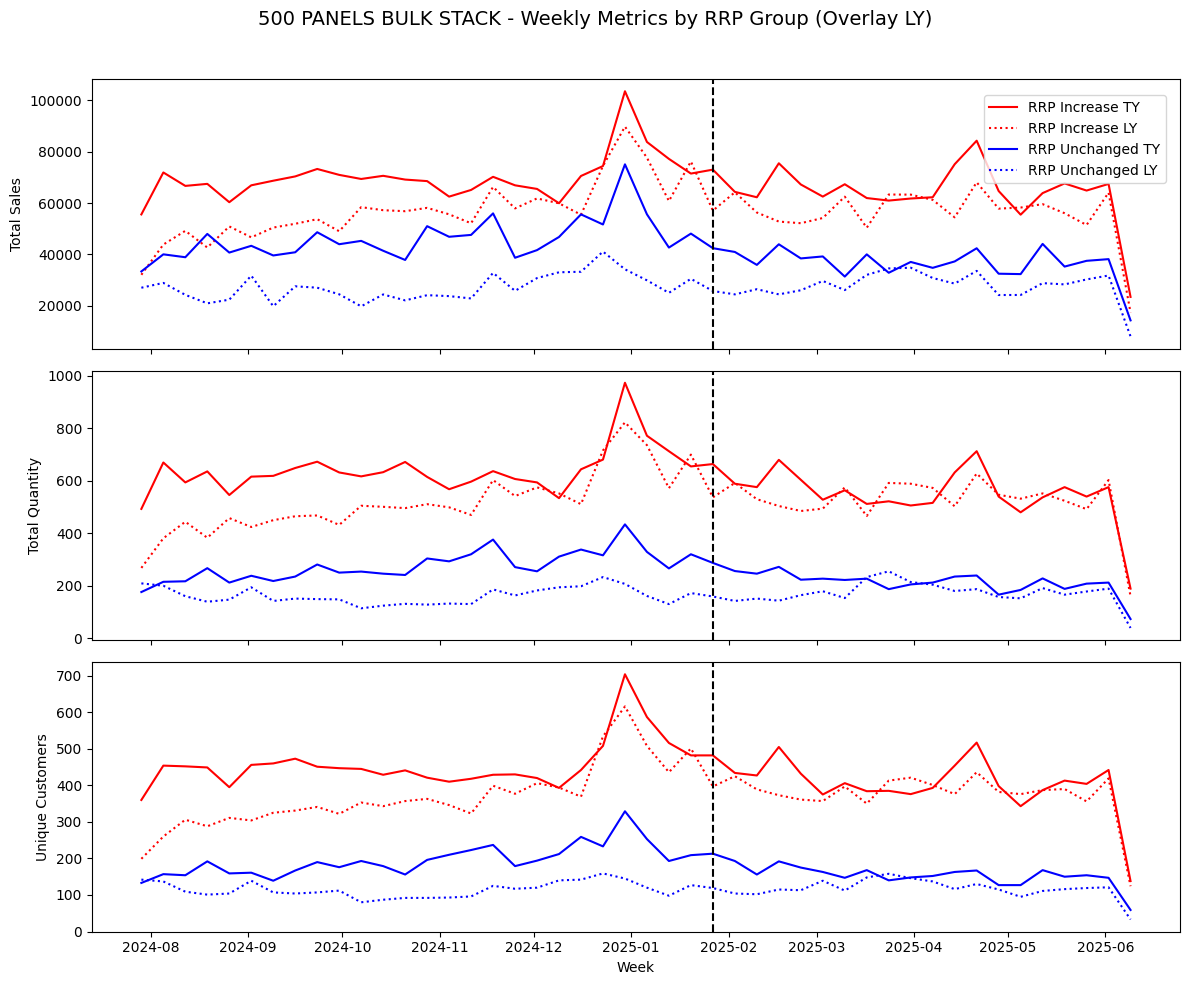

In [138]:
formatted_class_summaries = []

for class_name in df_all['item_class_name'].unique():
    df_class = df_all[df_all['item_class_name'] == class_name]
    df_weekly = df_class.groupby(
        ['week_start', 'rrp_increase', 'year_label']
    )[['total_sales', 'total_quantity', 'unique_customers']].sum().reset_index()

    df_summary = df_class.groupby(
        ['item_class_name', 'rrp_increase', 'period', 'year_label']
    )[['total_sales', 'total_quantity', 'unique_customers']].mean().reset_index().round(2)
    df_summary['rrp_order'] = df_summary['rrp_increase'].map({'Yes': 0, 'No': 1})
    df_summary['period_order'] = df_summary['period'].map({'Pre': 0, 'Post': 1})
    df_summary['year_order'] = df_summary['year_label'].map({'This Year': 0, 'Last Year': 1})
    df_summary = df_summary.sort_values(by=['item_class_name', 'rrp_order', 'period_order', 'year_order'])
    df_summary = df_summary.drop(columns=['rrp_order', 'period_order', 'year_order'])
    formatted_class_summaries.append(df_summary)

    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    fig.suptitle(f"{class_name} - Weekly Metrics by RRP Group (Overlay LY)", fontsize=14)

    for ax, metric in zip(axes, ['total_sales', 'total_quantity', 'unique_customers']):
        for rrp_status in ['Yes', 'No']:
            for year_label in ['This Year', 'Last Year']:
                group = df_weekly[
                    (df_weekly['rrp_increase'] == rrp_status) &
                    (df_weekly['year_label'] == year_label)
                ]
                x = group['week_start'] + pd.Timedelta(weeks=52) if year_label == 'Last Year' else group['week_start']
                ax.plot(
                    x, group[metric],
                    color=plot_colors[rrp_status],
                    linestyle=line_styles[year_label]
                )
        ax.axvline(pd.to_datetime(start_rrp_date), color='black', linestyle='--')
        ax.set_ylabel(metric.replace('_', ' ').title())

    axes[-1].set_xlabel("Week")

    # Custom legend
    legend_lines = [
        mlines.Line2D([], [], color='red', linestyle='solid', label='RRP Increase TY'),
        mlines.Line2D([], [], color='red', linestyle='dotted', label='RRP Increase LY'),
        mlines.Line2D([], [], color='blue', linestyle='solid', label='RRP Unchanged TY'),
        mlines.Line2D([], [], color='blue', linestyle='dotted', label='RRP Unchanged LY'),
    ]
    fig.legend(
        handles=legend_lines,
        loc='lower center',
        bbox_to_anchor=(0.9, 0.8),
        ncol=1,
        fontsize='medium'
    )

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


In [98]:
# Clean column names
df_class_transactions.columns = (
    df_class_transactions.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
)

# Ensure item_number is string with 7-digit padding
df_class_transactions['item_number'] = df_class_transactions['item_number'].astype(str).str.zfill(7)

# Mark RRP Increase based on au_items_enriched ---
df_class_transactions['rrp_increase'] = df_class_transactions['item_number'].isin(
    au_items_enriched['item_number']
).map({True: 'Yes', False: 'No'})

# Tag Pre/Post period ---
cutoff_date = pd.to_datetime(start_rrp_date)
df_class_transactions['period'] = pd.to_datetime(df_class_transactions['week_start']).apply(
    lambda x: 'Pre' if x < cutoff_date else 'Post'
)

#### Weekly trends summary

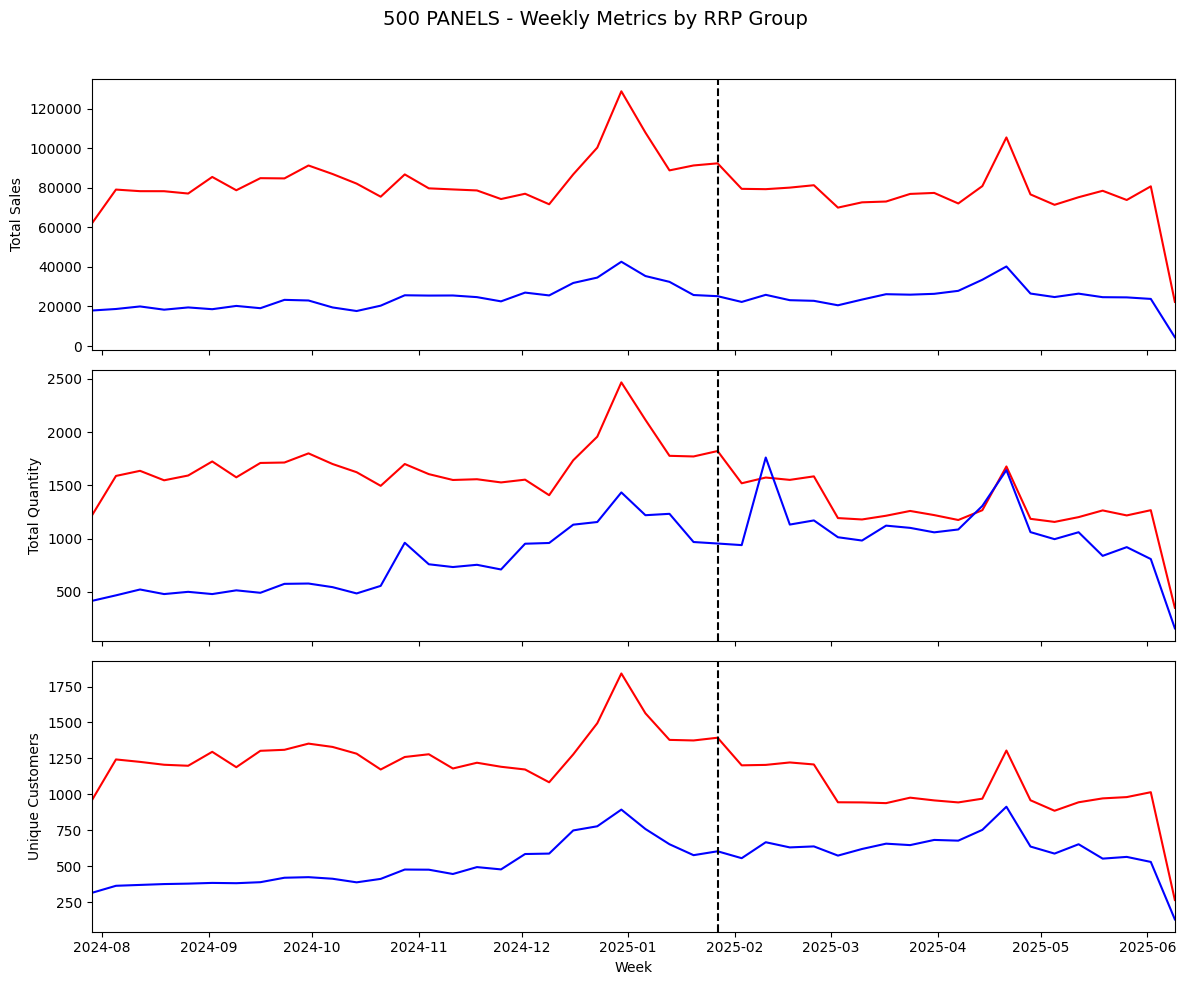

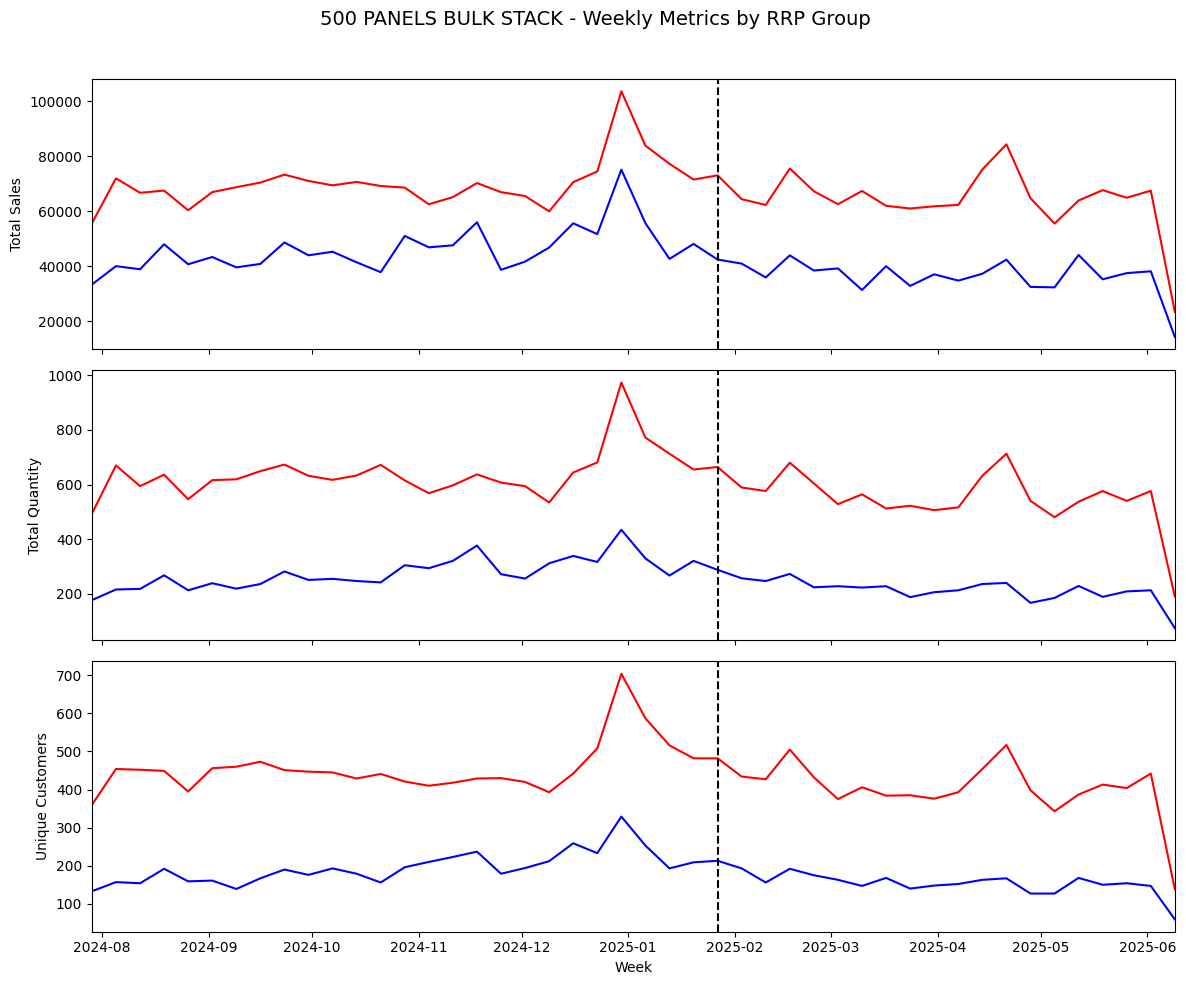

,item_class_name,rrp_increase,period,total_sales,total_quantity,unique_customers
0,500 PANELS,Yes,Pre,4022.98,79.98,61.15
1,500 PANELS,Yes,Post,3619.53,61.64,48.18
2,500 PANELS,No,Pre,945.09,29.09,19.27
3,500 PANELS,No,Post,956.15,40.44,23.52
4,500 PANELS BULK STACK,Yes,Pre,10004.89,91.43,65.23
5,500 PANELS BULK STACK,Yes,Post,9183.71,78.89,57.82
6,500 PANELS BULK STACK,No,Pre,4131.42,24.77,17.53
7,500 PANELS BULK STACK,No,Post,3703.68,21.81,15.78


In [108]:
# Plot colors
plot_colors = {'Yes': 'red', 'No': 'blue'}

# Storage for formatted summary table
formatted_class_summaries = []

# Loop by item class
for class_name in df_class_transactions['item_class_name'].unique():
    df_subset = df_class_transactions[df_class_transactions['item_class_name'] == class_name]

    # Weekly aggregate per RRP and period
    df_weekly = df_subset.groupby(['week_start', 'rrp_increase'])[
        ['total_sales', 'total_quantity', 'unique_customers']
    ].sum().reset_index()

    # Summary table by RRP and period
    df_summary = df_subset.groupby(['rrp_increase', 'period'])[
        ['total_sales', 'total_quantity', 'unique_customers']
    ].mean().reset_index().round(2)
    df_summary['item_class_name'] = class_name
    df_summary = df_summary[['item_class_name', 'rrp_increase', 'period', 'total_sales', 'total_quantity', 'unique_customers']]

    # Custom sort: Yes first, then No; Pre first, then Post
    df_summary['rrp_order'] = df_summary['rrp_increase'].map({'Yes': 0, 'No': 1})
    df_summary['period_order'] = df_summary['period'].map({'Pre': 0, 'Post': 1})
    df_summary = df_summary.sort_values(by=['rrp_order', 'period_order']).drop(columns=['rrp_order', 'period_order'])

    formatted_class_summaries.append(df_summary)

    # Plot all 3 metrics in one chart using subplots
    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    fig.suptitle(f"{class_name} - Weekly Metrics by RRP Group", fontsize=14)

    for ax, metric in zip(axes, ['total_sales', 'total_quantity', 'unique_customers']):
        for rrp_status in ['Yes', 'No']:
            group = df_weekly[df_weekly['rrp_increase'] == rrp_status]
            ax.plot(group['week_start'], group[metric], label=rrp_status, color=plot_colors[rrp_status])
        ax.axvline(start_rrp_date, color='black', linestyle='--')
        ax.set_ylabel(metric.replace('_', ' ').title())
        ax.set_xlim(df_weekly['week_start'].min(), df_weekly['week_start'].max())

    axes[-1].set_xlabel("Week")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Combine summary tables
final_summary_table = pd.concat(formatted_class_summaries, ignore_index=True)
final_summary_table